In [2]:
%pip install datasets transformers
%pip install Pillow
%pip install scikit-learn
%pip install matplotlib seaborn pandas geopandas numpy
%pip install accelerate -U
%pip install aiohttp -U

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import torch

print(torch.__version__)
torch.cuda.device_count(), torch.cuda.get_device_name(0)

2.3.0+cu118


(1, 'NVIDIA GeForce RTX 3060 Ti')

In [3]:
from typing import TypedDict
import math
import os, csv

DatasetItem = TypedDict('DatasetItem', {'filename': str, 'latitude': float, 'longitude': float, 'sector': int})

files = os.listdir('./dataset/images')
files = sorted(files, key=lambda x: int(x.split('.')[0]))

with open('./coords.csv', 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)   
    coords = list(reader)
    coords = [[float(lat), float(lon)] for lat, lon in coords]

def sector_from_coords(lat: float, lon: float) -> int:
    norm_lat = (lat + 90) / 180
    norm_lon = (lon + 180) / 360
    # do 36 by 18 sectors
    sector = math.floor(norm_lat * 18) * 36 + math.floor(norm_lon * 36)
    return sector


with open('./labels.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filename', 'latitude', 'longitude', 'sector'])
    for file_name, coord in zip(files, coords) :
        lat, lon = coord
        sector = sector_from_coords(lat, lon)
        writer.writerow([file_name, lat, lon, sector])


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/hchan/.cache/huggingface/datasets/csv/default-d839be5116ba3fbd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


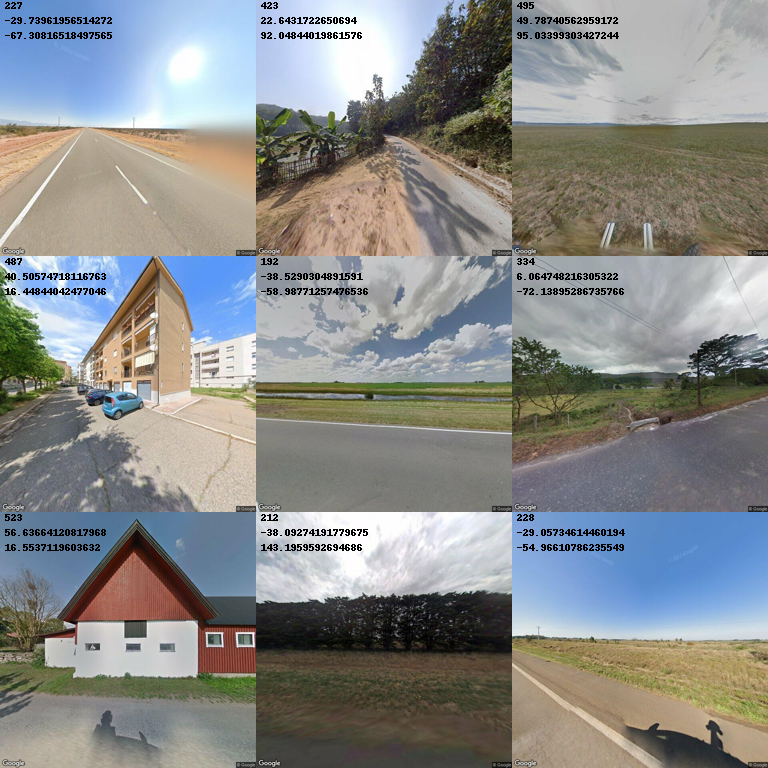

In [4]:
from datasets import load_dataset, Dataset # type: ignore
from PIL import Image, ImageDraw, ImageFont
from typing import Tuple, Set, List
import random

dataset = load_dataset("csv", data_files="./labels.csv", split='train').train_test_split(test_size=0.2) # type: ignore
train_labels = list(set(dataset["train"]["sector"])) # type: ignore
test_labels = list(set(dataset["test"]["sector"])) # type: ignore
labels = list(set(train_labels + test_labels))

def path(fn: str) -> str:
    return f"./dataset/images/{fn}"

def show_examples(train: Dataset, size: Tuple[int, int]):
    w, h = size
    items_in_dataset = train.num_rows
    square = 3

    keys: Set[int] = set()
    count = 0 

    grid = Image.new('RGB', size=(w * square, h * square))
    font = ImageFont.load_default()
    
    while count < square * square:
        rand = random.randrange(items_in_dataset)
        if rand in keys:
            continue
        keys.add(rand)

        item: DatasetItem = train[rand] # type: ignore
        file_name = item["filename"]
        image = Image.open(path(file_name)) # type: ignore
        x = count % square
        y = count // square
        grid.paste(image.resize((w, h)), (x * w, y * h)) # type: ignore
        draw = ImageDraw.Draw(grid) # type: ignore

        sector = item["sector"]
        lat = item["latitude"]
        lon = item["longitude"]

        draw.text((x * w + 5 , y * h), str(sector), font=font, fill=(0,0,0)) # type: ignore
        draw.text((x * w + 5, y * h + 15), str(lat), font=font, fill=(0,0,0)) # type: ignore
        draw.text((x * w + 5, y * h + 30), str(lon), font=font, fill=(0,0,0)) # type: ignore
        count += 1
        
    return grid

show_examples(dataset["train"], size=(256, 256)) # type: ignore

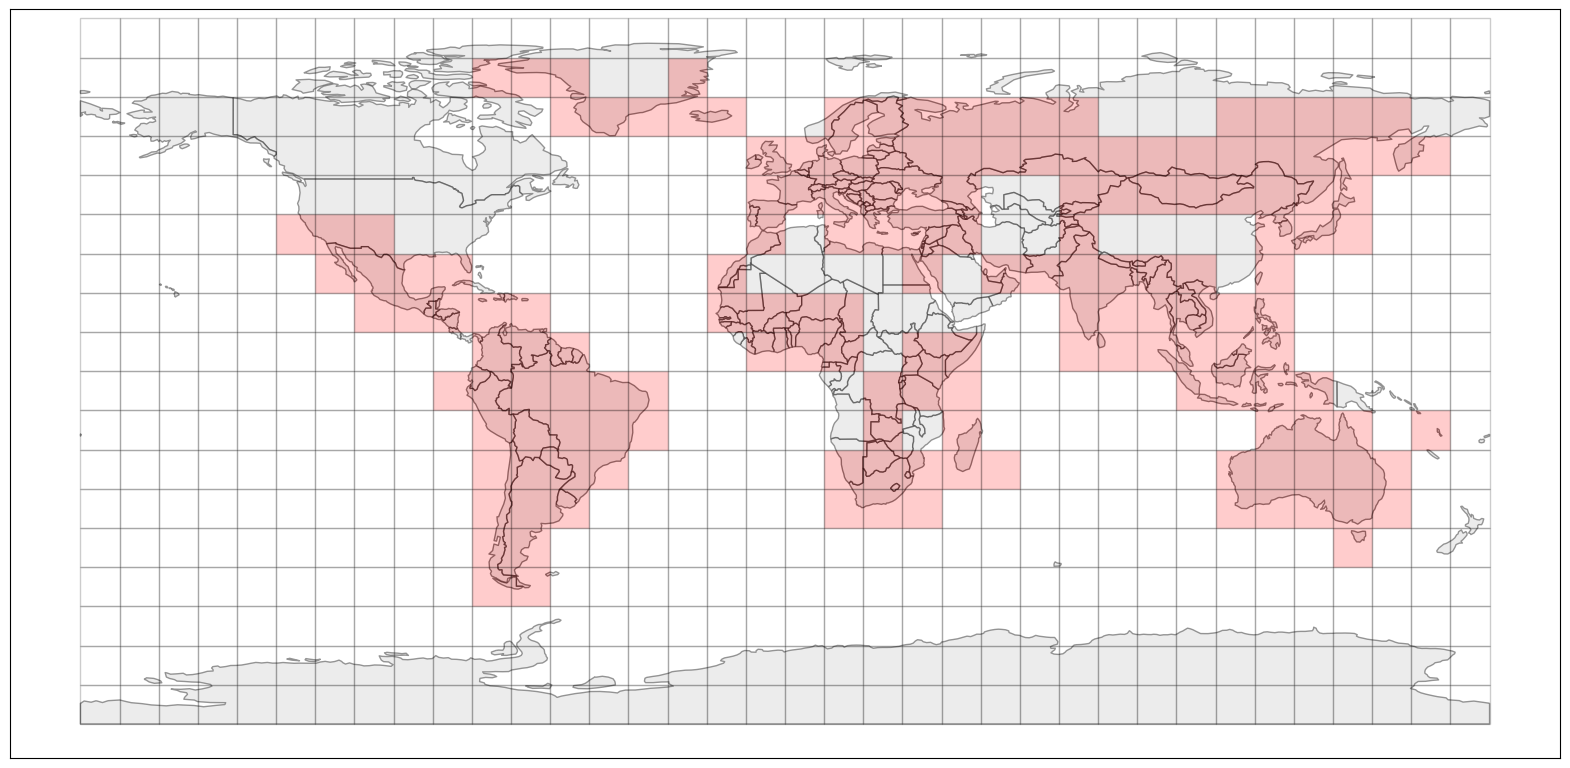

In [5]:
# type: ignore

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

world.plot(
    ax=ax,
    color="lightgray",
    edgecolor="black",
    alpha=0.5
)

for sector in range(36 * 18):
    x, y = (sector % 36) * 10, (sector // 36) * 10
    rect = patches.Rectangle((x - 180, y - 90), 10, 10, linewidth=1, edgecolor='black', facecolor='red' if sector in labels else "white", alpha=0.2)
    ax.add_patch(rect)

# turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [6]:
from transformers import ViTImageProcessor # type: ignore

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path) # type: ignore

In [7]:
# type: ignore
from PIL import Image
from typing import List

def transform(batch: List[DatasetItem]):
    inputs = processor([Image.open(path(x)) for x in batch['filename']], return_tensors='pt')
    inputs['labels'] = labels
    return inputs

prepared_dataset = dataset.with_transform(transform)

In [8]:
# type: ignore

import numpy as np
from datasets import load_metric 
from transformers import BatchFeature
import torch

def collate_fn(batch: List[BatchFeature]):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


metric = load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

C:\Users\hchan\AppData\Local\Temp\ipykernel_320\803600054.py:15: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [9]:
# type: ignore

from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# type: ignore

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./vit-base-lucabot",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_dataset["train"],
    eval_dataset=prepared_dataset["test"],
    tokenizer=processor,
)

In [11]:
# type: ignore

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

metrics = trainer.evaluate(prepared_dataset["test"])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

c:\Users\hchan\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
